# mapping Faults into Underworld2

This notebook uses the PyMesh libraray (wrapping up many third-party tools) to map the Southern California faults into Underworld2. 

The faults are from version 5.0 of the SCEC Community Fault Model (CFM) for southern California

In [1]:
import pymesh
import numpy as np
from glob import glob

In [2]:
##Read a goCAD Tsurf file and extract vertices and triangle connectivity

def read_tsurf(filename):
    with open(filename, 'r') as infile:
        firstline = next(infile).strip()
        if not firstline.startswith('GOCAD TSurf'):
            raise IOError('This is not a valid TSurf file!')

        # Parse Header
        header = {}
        line = next(infile).strip()
        if line.startswith('HEADER'):
            line = next(infile).strip()
            while '}' not in line:
                key, value = line.split(':')
                header[key.lstrip('*')] = value
                line = next(infile).strip()
        name = header.get('name', filename)
        print(name)
        line = next(infile).strip()
        while 'TFACE' not in line:
            line = next(infile).strip()
            #print(line)
    
    
        # Read vertices and triangles
        if not line.startswith('TFACE'):
            raise IOError('Only "TFACE" format TSurf files are supported')
        vertices, faces = [], []
        for line in infile:
            line = line.strip().split()
            if line[0] == 'VRTX':
                vertices.append([float(item) for item in line[2:]])
            elif line[0] == 'TRGL':
                faces.append([int(item)-1 for item in line[1:]])
    #x, y, z = zip(vertices)
    return(vertices, faces)

In [3]:
#test loading in a fault...

vertices, faces = read_tsurf('CFM5_release_2014/tsurf/CFM5_socal_primary/SALT-IMFZ-IMPV-Imperial_fault-east-strand-south-CFM5.ts')


SALT-IMFZ-IMPV-Imperial_fault-east-strand-south-CFM5


In [4]:
all_faults = glob('CFM5_release_2014/tsurf/CFM5_socal_primary/*.ts')

In [5]:
#few_faults = all_faults[::len(all_faults)/5]
#few_faults 

In [6]:
#Read in a few of those faults as PyMesh meshes

fault_meshes = []
for fault in all_faults:
    try:  #Still some bugs in the goCad-parser
        vertices, faces = read_tsurf(fault)
        F = np.array(faces).astype('int32')
        V = np.array(vertices).astype('float64')
        faultmesh = pymesh.form_mesh(V, F)
        fault_meshes.append(faultmesh)
    except:
        pass

BNRA-BMFZ-MULT-Black_Mountain_fault-CFM3
BNRA-NDVZ-MULT-Northern_Death_Valley_fault-CFM2
BNRA-SDVZ-MULT-Southern_Death_Valley_fault-vertical-CFM3
CRFA-BPPM-EAST-Big_Pine_fault-CFM4
CRFA-BPPM-LCKV-Lockwood_Valley_fault-CFM2
CRFA-BPPM-PMTS-Pine_Mountain_fault-CFM2
CRFA-BPPM-WEST-Big_Pine_fault-CFM2
CRFA-CSBL-CSML-Casmalia_fault-CFM4
CRFA-CSBL-LALM-Los_Alamos_fault-steep-CFM5
CRFA-CSBL-ORCT-Orcutt_blind_fault-CFM5
CRFA-CSBL-PEZN-Pezzoni_Casmalia_fault-truncated-CFM5
CRFA-CSBL-ZACA-Zaca_blind_fault-CFM5
CRFA-LMPZ-EAST-Lompoc_blind_ramp-CFM5
CRFA-LMPZ-WEST-Lompoc_blind_ramp-CFM5
CRFA-LNHZ-MULT-Lions_Head_fault-CFM4
CRFA-LOSO-LSOS-Los_Osos_fault-CFM4
CRFA-LPNZ-MULT-La_Panza_fault-CFM4
CRFA-NAFZ-MULT-Nacimiento_fault-south-CFM2
CRFA-OCNZ-SLCR-Oceanic_backthrust-CFM4
CRFA-OCNZ-SLCR-Oceanic_fault-CFM4
CRFA-REHZ-EHSN-East_Huasna_fault-CFM4
CRFA-REHZ-MULT-Rinconada_fault-CFM4
CRFA-SCFZ-SCYM-South_Cuyama_fault-CFM3
CRFA-SJMZ-MRLS-Morales_fault-CFM3
CRFA-SLRS-MULT-San_Luis_Range_fault_system-CFM4
C

In [7]:
len(fault_meshes)

322

In [8]:
#Get the bounding box of all faults, just as a quick way to define a domain:

bbox = fault_meshes[0].bbox
for surf in fault_meshes:
    fbox = surf.bbox
    bbox = (np.minimum(bbox[0],fbox[0]), np.maximum(bbox[1],fbox[1]))
    

#test1.bbox

## Underworld

In [2]:
try :
    if(__IPYTHON__) :
        get_ipython().magic(u'matplotlib inline')
except NameError :
    pass

import math
import os

import underworld as uw
from underworld import function as fn
from underworld import meshvariable as meshvariable
import glucifer

import mpi4py
comm = mpi4py.MPI.COMM_WORLD

In [11]:
minX  = bbox[0][0]
minY  = bbox[0][1]
minZ  = bbox[0][2]

maxX  = bbox[1][0]
maxY  = bbox[1][1]
maxZ  = 0.0 #Make this one at surface
#minXv = -1.0
#maxXv =  1.0

resX = 32
resY = 32
resZ = 8

elementType="Q2/dPc1"  # This is enough for a test but not to use the code in anger

mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = ( resX, resY, resZ), 
                                 minCoord    = ( minX, minY, minZ), 
                                 maxCoord    = ( maxX, maxY, maxZ),
                                 periodic    = [False, False, False]  ) 



velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
pressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.,0.]
pressureField.data[:] = 0.

## Initialise swarm variables

In [12]:
swarm  = uw.swarm.Swarm( mesh=mesh )
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=50 )
swarm.populate_using_layout( layout=swarmLayout )

# For population control, make this an integration swarm
popSwarm = uw.swarm.PICIntegrationSwarm(swarm, particlesPerCell=10)

surfaceSwarm = uw.swarm.Swarm( mesh=mesh )
deformationSwarm = uw.swarm.Swarm ( mesh=mesh )

materialVariable = swarm.add_variable( dataType="int", count=1 )
faultDistance = swarm.add_variable( dataType="float", count=1 )


In [13]:
materialV = 0 # viscoplastic
materialF = 1 # nearfault

In [14]:
materialVariable.data[:] = 0
faultDistance.data[:] = 1e6 #a meaningless number 

In [15]:
swarm.particleCoordinates.data.shape

(409600, 3)

In [16]:
## Lets compute the distance information. Three values are returned in the tuple.

#squared_distances: squared distances from each point to mesh.
#face_indices : the closest face to each point.
#closest_points: the point on mesh that is closest to each
 

In [17]:
distances = pymesh.distance_to_mesh(fault_meshes[0], swarm.particleCoordinates.data[:])

In [18]:
actual_dist = np.sqrt(distances[0])

In [19]:
faultDistance.data.shape

(409600, 1)

In [20]:
faultDistance.data[:,0]

array([ 1000000.,  1000000.,  1000000., ...,  1000000.,  1000000.,
        1000000.], dtype=float32)

In [21]:
test = np.minimum.reduce([faultDistance.data[:, 0],actual_dist])
test.shape

(409600,)

In [22]:
len(fault_meshes[::20])

17

In [23]:
distance_array = np.copy(faultDistance.data)
distance_array[:, 0].shape

(409600,)

In [24]:
distance_array = np.ones(len(swarm.particleCoordinates.data[:]))
distance_array.shape

(409600,)

In [25]:
#I found there are particular faults that were casusing wierd PETSC? crashes; 

distance_array = np.ones(len(swarm.particleCoordinates.data[:]))*1e7
count = 1
for fault in fault_meshes[2::20]:
    distances = pymesh.distance_to_mesh(fault, swarm.particleCoordinates.data[:])
    actual_dist = distances[0]
    distance_array[:] = np.minimum.reduce([distance_array[:] ,actual_dist])
    print("finished " + str(count))
    %xdel distances
    %xdel actual_dist
    count += 1

finished 1
finished 2
finished 3
finished 4
finished 5
finished 6
finished 7
finished 8
finished 9
finished 10
finished 11
finished 12
finished 13
finished 14
finished 15
finished 16


In [26]:
faultDistance.data[:,0] = np.sqrt(distance_array[:])

In [27]:
conditions = [ (       faultDistance > 1e3 , materialV ),
               (       True ,           materialF ) ]

materialVariable.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)


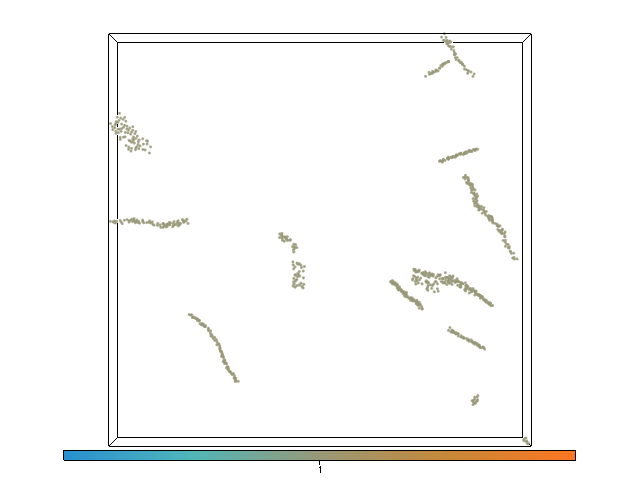

In [30]:
figMat = glucifer.Figure()
figMat.append( glucifer.objects.Points(swarm, materialVariable, pointSize=4.0, fn_mask=materialVariable) )
#figMat.append( glucifer.objects.Mesh(mesh))
figMat.save_database('test.gldb')
figMat.show()